# Using pre-trained embedding with Tensorflow Hub

**Learning Objectives**
1. How to instantiate a Tensorflow Hub module
1. How to find pretrained Tensorflow Hub module for variety of purposes
1. How to use a pre-trained TF Hub text modules to generate sentence vectors
1. How to incorporate a pre-trained TF-Hub module into a Keras model



## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple models starting with different pre-trained TF-Hub layers.

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 KB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 2.2.1 requires google-resumable-media>=2.3.2, but you have google-resumable-media 0.5.1 which is incompatible.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.41.0 which is incompatible.


**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-01-7bff2816dcba"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "australia-southeast1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [4]:
%%bigquery --project $PROJECT

SELECT url, title, score
FROM `bigquery-public-data.hacker_news.stories`
WHERE LENGTH(title) > 10
AND score > 10
AND LENGTH(url) > 0
LIMIT 10

,url,title,score
0,https://www.kickstarter.com/projects/carlosxcl...,"Show HN: Code Cards, Like Texas hold 'em for p...",11
1,http://vancouver.en.craigslist.ca/van/roo/2035...,Best Roommate Ad Ever,11
2,https://github.com/Groundworkstech/Submicron,Deep-Submicron Backdoors,11
3,http://empowerunited.com/,Could this be the solution for the 99%?,11
4,http://themanufacturingrevolution.com/braun-vs...,Braun vs. Apple: Is copying designs theft or i...,11
5,https://github.com/styleguide/,"GitHub Styleguide - CSS, HTML, JS, Ruby",11
6,http://zoomzum.com/10-best-firefox-add-ons-to-...,Essential Firefox Add-Ons to Make You More Pro...,11
7,http://www.zintin.com,Feedback on our social media iPhone app,11
8,http://founderdating.com/comingtodinner/,Guess Who’s Coming to Dinner…To Save Our Company,11
9,http://tech.matchfwd.com/poor-mans-template-ab...,Poor Man's Template A/B Testing (in Django),11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL.

In [5]:
%%bigquery --project $PROJECT

SELECT ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source, COUNT(title) AS num_articles
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
AND LENGTH(title) > 10
GROUP BY source
ORDER BY num_articles DESC LIMIT 100

,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787
...,...,...
95,f5,1254
96,gamasutra,1249
97,cnbc,1229
98,indiatimes,1223


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT title, ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[OFFSET(1)] AS source
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title, source
FROM ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title, source
FROM (
SELECT title, ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head(7)

,title,source
0,feminist-software-foundation complains about r...,github
1,expose sps as web services on the fly.,github
2,show hn scrwl shorthand code reading and wr...,github
3,geoip module on nodejs now is a c addon,github
4,show hn linuxexplorer,github
5,mysql minutiae innodb internals,github
6,vilfredo pareto on software product management,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last column to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 96203 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [12]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        383
nytimes       322
techcrunch    295
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [13]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [14]:
sample_title_dataset.head()

,title,source
3306,core data editor,github
56150,that flawed stanford study,nytimes
79133,unesco mobile devices can improve literacy ra...,techcrunch
45619,by becoming a cook you can leave processed fo...,nytimes
76230,jawbone patents body fat percentage measuremen...,techcrunch


In [15]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.6.3


In [16]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [17]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [18]:
ls ./data/

titles_full.csv  titles_sample.csv


In [19]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,the most powerful force on the universe,techcrunch
1,the internet archive now lets you play 900 cl...,techcrunch
2,transfer jet 375 mb s wireless connection,nytimes
3,patientslikeme,nytimes
4,a new fashion catches on in paris - cheap bicy...,nytimes


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [20]:
titles_df.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [21]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}

N_CLASSES = len(CLASSES)

In [22]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    return to_categorical(classes, num_classes=N_CLASSES)

In [23]:
encode_labels(titles_df.source[:4])

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [24]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])
titles_valid, sources_valid = (titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [25]:
sources_train.value_counts()

github        34703
techcrunch    29328
nytimes       27361
Name: source, dtype: int64

In [26]:
sources_valid.value_counts()

github        1822
techcrunch    1563
nytimes       1426
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [27]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [28]:
X_train[:3]

array(['the most powerful force on the universe',
       'the internet archive now lets you play 900  classic arcade games in your browser',
       'transfer jet  375 mb s wireless connection'], dtype=object)

In [29]:
Y_train[:3]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [30]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

2022-03-25 10:06:06.977844: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-25 10:06:07.140455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [31]:
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `nnlm_module` we constructed above) as well as the name of the model (say `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [32]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO 
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [40]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data
    tf.random.set_seed(33)
    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)
    history = model.fit(
        X_train, Y_train,
        epochs=13, # 100
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[TensorBoard(model_dir)], # EarlyStopping()
    )
    return history

## Training NNLM

In [41]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [42]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

2022-03-25 10:09:54.386050: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 10:09:54.386089: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-25 10:09:54.386293: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/13
 1/19 [>.............................] - ETA: 14s - loss: 0.7806 - accuracy: 0.8766

2022-03-25 10:09:55.282434: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 10:09:55.282474: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/19 [==>...........................] - ETA: 6s - loss: 0.7753 - accuracy: 0.8792 

2022-03-25 10:09:55.686734: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-25 10:09:55.688413: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 10:09:55.690290: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2022_03_25_10_09_55

2022-03-25 10:09:55.691250: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/nnlm/train/plugins/profile/2022_03_25_10_09_55/tensorflow-2-6-20220325-225416.trace.json.gz
2022-03-25 10:09:55.694766: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2022_03_25_10_09_55

2022-03-25 10:09:55.695590: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./text_models/nnlm/train/plugins/profile/2022_03_25_

19/19 [==============================] - 7s 361ms/step - loss: 0.6945 - accuracy: 0.8970 - val_loss: 0.6623 - val_accuracy: 0.8283
Epoch 2/13
19/19 [==============================] - 6s 329ms/step - loss: 0.5280 - accuracy: 0.9146 - val_loss: 0.5378 - val_accuracy: 0.8377
Epoch 3/13
19/19 [==============================] - 6s 335ms/step - loss: 0.4055 - accuracy: 0.9151 - val_loss: 0.4573 - val_accuracy: 0.8410
Epoch 4/13
19/19 [==============================] - 7s 338ms/step - loss: 0.3281 - accuracy: 0.9144 - val_loss: 0.4173 - val_accuracy: 0.8410
Epoch 5/13
19/19 [==============================] - 6s 334ms/step - loss: 0.2839 - accuracy: 0.9159 - val_loss: 0.4001 - val_accuracy: 0.8427
Epoch 6/13
19/19 [==============================] - 6s 335ms/step - loss: 0.2569 - accuracy: 0.9185 - val_loss: 0.3938 - val_accuracy: 0.8437
Epoch 7/13
19/19 [==============================] - 6s 331ms/step - loss: 0.2386 - accuracy: 0.9217 - val_loss: 0.3934 - val_accuracy: 0.8414
Epoch 8/13
19/19 

<AxesSubplot:>

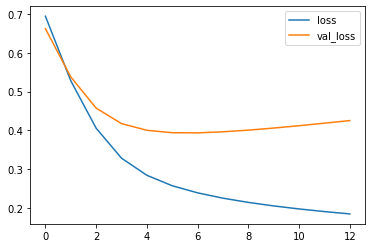

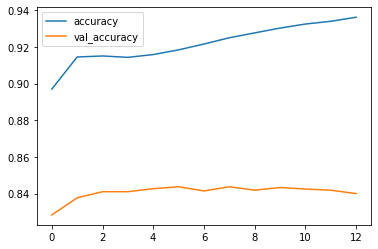

In [43]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License